# IDTreeS competition dataset

## Refs and links

[Dataset](https://zenodo.org/record/3934932) from the [IDTreeS competition, 2020](https://idtrees.org/competition/):

* `train`: task 1 training dataset from [IDTREES_competition_train_v2.zip](https://zenodo.org/record/3934932/files/IDTREES_competition_train_v2.zip?download=1);
* `test`: test dataset from [IDTREES_competition_test_v2.zip](https://zenodo.org/record/3934932/files/IDTREES_competition_test_v2.zip?download=1).

## Exploring the training dataset

We look at the only true-color images (RGB), while the dataset also includes hyperspectral images(HSI), point-cloud data (LAS) and canopy height model (CHM). Individual tree-crowns (ITCs) are provided as vector data, tree classes are defined in a separate CSV file. 

In [75]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
import numpy as np
import tensorflow as tf

2023-08-30 11:36:58.003386: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-30 11:36:58.158060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
# data paths
region = 'MLBS'
rgb_path = f'./train/RemoteSensing/RGB/{region}_1.tif'  # first sample
bboxes_path = f'./train/ITC/train_{region}.shp'
classes_path = f'./train/Field/train_data.csv'

In [98]:
# load true-color image
rgb = rioxarray.open_rasterio(rgb_path, masked=True)

In [99]:
# load bboxes
bboxes = geopandas.read_file(bboxes_path)

In [6]:
assert bboxes.crs == rgb.rio.crs

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

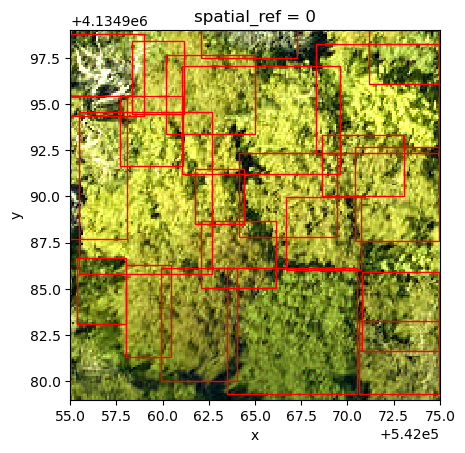

In [7]:
# plot labels within the sample
fig, ax = plt.subplots()
rgb.plot.imshow(ax=ax, robust=True)
xmin, ymin, xmax, ymax = rgb.rio.bounds()
# bboxes_clip = bboxes.clip_by_rect(xmin, ymin, xmax, ymax)
bboxes_clip = bboxes.cx[xmin:xmax, ymin:ymax]
bboxes_clip = bboxes_clip[~bboxes_clip.is_empty]
bboxes_clip.plot(ax=ax, facecolor='none', edgecolor='red')

In [ ]:
# make cutouts and plot them out
# for bbox in bboxes_clip:
for bbox in bboxes_clip.geometry:
    cutout = rgb.rio.clip([bbox], drop=True)
    aspect = cutout.rio.width / cutout.rio.height
    cutout.plot.imshow(robust=True, aspect=aspect, size=1, x='x', y='y')
    plt.show()

In [9]:
# load classes
classes = pd.read_csv(classes_path)

In [10]:
# number of unique classes
classes['taxonID'].nunique()

33

## Set up data loader

In [11]:
import glob

from rioxarray.exceptions import NoDataInBounds

In [100]:
rgb_paths = glob.glob('./train/RemoteSensing/RGB/*.tif')
bboxes_paths = glob.glob('./train/ITC/train_*.shp')
classes_path = './train/Field/train_data.csv'

In [132]:
class IDTreeSDataset:
    
    def __init__(self, rgb_paths, bboxes_paths, classes_path):
        self.rgb_paths = rgb_paths
        self.bboxes_paths = bboxes_paths
        self.classes_path = classes_path
        
    def generate_cutouts(self):
        # load bboxes
        bboxes = pd.concat([
            geopandas.read_file(p)
            for p in self.bboxes_paths
        ])
        
        # load classes 
        classes = pd.read_csv(self.classes_path)
        classes = classes.set_index('indvdID')

        # load rgb data and make cutouts
        for rgb_path in self.rgb_paths:
            rgb = rioxarray.open_rasterio(rgb_path, masked=True)
            
            assert bboxes.crs == rgb.rio.crs

            # select relevant bboxes
            xmin, ymin, xmax, ymax = rgb.rio.bounds()
            bboxes_clip = bboxes.cx[xmin:xmax, ymin:ymax]
            bboxes_clip = bboxes_clip[~bboxes_clip.is_empty]
            
            for _, bbox in bboxes_clip.iterrows():
                
                indvdID = bbox['indvdID']

                if indvdID not in classes.index:
                    # issue: for some IDs, the class is not specified
                    continue
                
                label = classes.loc[indvdID]['taxonID']
                if not isinstance(label, str):
                    # issue: there are multiple entries for the same ID
                    continue
                
                try:
                    cutout = rgb.rio.clip([bbox.geometry], drop=True)
                    data, flag = _image_preprocessor(cutout.data)
                    print (flag)
                    if flag:
                        # If image is too small or too large
                        continue
                except NoDataInBounds:
                    # issue: some polygons have very small intersections with the images
                    continue
                yield indvdID, label, data
    
def _image_preprocessor(data):
    # if (_remove_large_image(data) or _remove_small_images(data)):
        # return data, True
    data = _image_padding(data)
    return data, False

def _remove_large_image(data):
    if max(data.shape[1:]) > 500:
        return True
    return False

def _remove_small_images(data):
    if min(data.shape[1:]) <= 0:
        return True
    return False

def _image_padding(data):
    #Pad each image 
    pad_width_x1 = np.floor((100 - data.shape[1])/2).astype(int)
    pad_width_x2 = 100 - data.shape[1] - pad_width_x1 
    pad_width_y1 = np.floor((100 - data.shape[2])/2).astype(int)
    pad_width_y2 = 100 - data.shape[2] - pad_width_y1
    data = np.pad(data, pad_width=[(0, 0),(pad_width_x1, pad_width_x2),(pad_width_y1, pad_width_y2)], mode='constant')
    return data
        

        

In [134]:
# instantiate generator
ds = IDTreeSDataset(rgb_paths, bboxes_paths, classes_path)
cutouts = ds.generate_cutouts()

In [135]:
%%time
# load all training dataset, with labels
data = ((id, l, arr) for id, l, arr in cutouts)
df = pd.DataFrame.from_records(data)

TypeError: IDTreeSDataset._image_preprocessor() takes 1 positional argument but 2 were given

In [131]:
df.shape

(538, 3)

Use generator to setup tensorflow dataset:

In [118]:
ds = IDTreeSDataset(rgb_paths, bboxes_paths, classes_path)

ds = tf.data.Dataset.from_generator(
    ds.generate_cutouts,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(3, None, None), dtype=tf.float32)
    )
)

In [119]:
len(list(ds))

2023-08-30 11:55:16.331037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


538

In [101]:
bboxes = geopandas.read_file(bboxes_path)

In [102]:
len(bboxes)

708